This is a neural network implementation with different number of linear layers.  

- Implemented functions:
    - Train NN 
    - Plot graph with decision boundaries
        - Because we use sampling for each iteration, last sampled data was displayed used for plot (so there is a subtle difference between displayed points in each test) 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import scipy.stats as stats

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

In [2]:
# Normal distribution parameters
mu0, sigma0 = -2., 1.
mu1, sigma1 = 3., 2.

In [3]:
class NetTester:
    def __init__(self, mu0, sigma0, mu1, sigma1, net, net_opt, lr=1e-3,
                 train_size=1024, val_size=100000, num_epochs=10000, log_freq=500,
                 random_state=42):
        self.mu0 = mu0
        self.sigma0 = sigma0
        self.mu1 = mu1
        self.sigma1 = sigma1
        self.net = net
        self.net_opt = net_opt
        self.lr = lr
        self.train_size = train_size
        self.val_size = val_size
        self.num_epochs = num_epochs
        self.log_freq = log_freq
        self.random_state = random_state
        
        torch.manual_seed(self.random_state)
     
    # Sample data from normal distribution with different parameters for label 0 and label 1 
    @staticmethod
    def _sample(d0, d1, n=32):
        x0 = d0.sample((n,))
        x1 = d1.sample((n,))
        y0 = torch.zeros((n, 1))
        y1 = torch.ones((n, 1))
        return torch.cat([x0, x1], 0), torch.cat([y0, y1], 0)
    
    # Reinitialize weights for training (for reproducible results)
    def _init_weights(self, submodule):
        if type(submodule) == nn.Linear:
            submodule.reset_parameters()
    
    # Prepare parameters for plotting graph
    def _prepare_plot_params(self):
        plot_params = {}

        x_scale = np.linspace(-5, 5, 100)
        y_scale = np.linspace(-5, 5, 100)
        X, Y = np.meshgrid(x_scale, y_scale)
        XY = np.c_[X.ravel(), Y.ravel()]

        pos = np.empty(X.shape + (2,))
        pos[:, :, 0] = X; pos[:, :, 1] = Y

        rv1 = stats.multivariate_normal([self.mu0, self.mu0], 
                                        [[self.sigma0**2, 0], [0, self.sigma0**2]])
        rv2 = stats.multivariate_normal([self.mu1, self.mu1], 
                                        [[self.sigma1**2, 0], [0, self.sigma1**2]])
        d0_pdf = rv1.pdf(pos)
        d1_pdf = rv2.pdf(pos)
        ratio = d1_pdf / (d1_pdf + d0_pdf)

        XY_tensor = torch.tensor(XY, dtype=torch.float)
        with torch.no_grad():
            sigmoid = torch.sigmoid(self.net(XY_tensor)).numpy()
        sigmoid = sigmoid.reshape(X.shape)
        
        self._X = X
        self._Y = Y
        self._d0_pdf = d0_pdf
        self._d1_pdf = d1_pdf
        self._ratio = ratio
        self._sigmoid = sigmoid
    
    # NN training
    def train_nn(self, verbose=False):
        self.net.apply(self._init_weights)
        self.net_opt = self.net_opt(lr=self.lr, params=list(self.net.parameters()))
    
        d0 = torch.distributions.Normal(torch.tensor([self.mu0, self.mu0]), 
                                        torch.tensor([self.sigma0, self.sigma0]))
        d1 = torch.distributions.Normal(torch.tensor([self.mu1, self.mu1]), 
                                        torch.tensor([self.sigma1, self.sigma1]))
        
        for i in range(self.num_epochs):
            if (i % self.log_freq == 0) and verbose:
                with torch.no_grad():
                    x, y = self._sample(d0, d1, self.val_size)
                    out = self.net(x)
                    loss = F.binary_cross_entropy_with_logits(out, y)
                print('Ошибка после %d итераций: %f' %(i / self.log_freq, loss))
            self.net_opt.zero_grad()
            x, y = self._sample(d0, d1, self.train_size)
            out = self.net(x)
            loss = F.binary_cross_entropy_with_logits(out, y)
            loss.backward()
            self.net_opt.step()
            
        self._x = x
        self._y = y
    
    # Plot contour plots (d0, d1, ratio, sigmoid)
    def plot_contour(self, title=''):
        self._prepare_plot_params()
        
        fig, axes = plt.subplots(figsize=(10, 10))

        contour_d0 = plt.contour(self._X, self._Y, self._d0_pdf, colors='black')
        plt.clabel(contour_d0, colors='black')
        plt.imshow(self._d0_pdf, extent = [-5, 5, -5, 5], cmap='Blues', origin='lower', alpha=0.5)

        contour_d1 = plt.contour(self._X, self._Y, self._d1_pdf, colors='black')
        plt.clabel(contour_d1, colors='black')
        plt.imshow(self._d1_pdf, extent = [-5, 5, -5, 5], cmap='Oranges', origin='lower', alpha=0.5)

        contour_ratio = plt.contour(self._X, self._Y, self._ratio, levels=[0, 0.5, 1], colors='red')
        plt.clabel(contour_ratio, colors='red')

        contour_sigmoid = plt.contour(self._X, self._Y, self._sigmoid, levels=[0, 0.5, 1], colors='green')
        plt.clabel(contour_sigmoid, colors='green')

        points = plt.scatter(self._x[:, 0], self._x[:, 1], alpha=0.1, c=self._y.squeeze())

        plt.axis('off')
        plt.xlim(-5, 5)
        plt.ylim(-5, 5)
        plt.title(title, {'fontsize': 14})

        d0_patch = mpatches.Patch(color='blue', label='Label 0')
        d1_patch = mpatches.Patch(color='orange', label='Label 1')
        ratio_patch = mpatches.Patch(color='red', label='Ratio')
        sigmoid_patch = mpatches.Patch(color='green', label='Sigmoid')
        plt.legend(handles=[d0_patch, d1_patch, ratio_patch, sigmoid_patch],
                   loc='right', bbox_to_anchor=(1.15, 0.95))
        plt.tight_layout()
        plt.show()

Ошибка после 0 итераций: 0.108714
Ошибка после 1 итераций: 0.093879
Ошибка после 2 итераций: 0.083175
Ошибка после 3 итераций: 0.076578
Ошибка после 4 итераций: 0.070821
Ошибка после 5 итераций: 0.067072
Ошибка после 6 итераций: 0.063867
Ошибка после 7 итераций: 0.061368
Ошибка после 8 итераций: 0.058498
Ошибка после 9 итераций: 0.056802
Ошибка после 10 итераций: 0.054161
Ошибка после 11 итераций: 0.053697
Ошибка после 12 итераций: 0.052009
Ошибка после 13 итераций: 0.050691
Ошибка после 14 итераций: 0.049417
Ошибка после 15 итераций: 0.048219
Ошибка после 16 итераций: 0.047195
Ошибка после 17 итераций: 0.046551
Ошибка после 18 итераций: 0.045973
Ошибка после 19 итераций: 0.045459


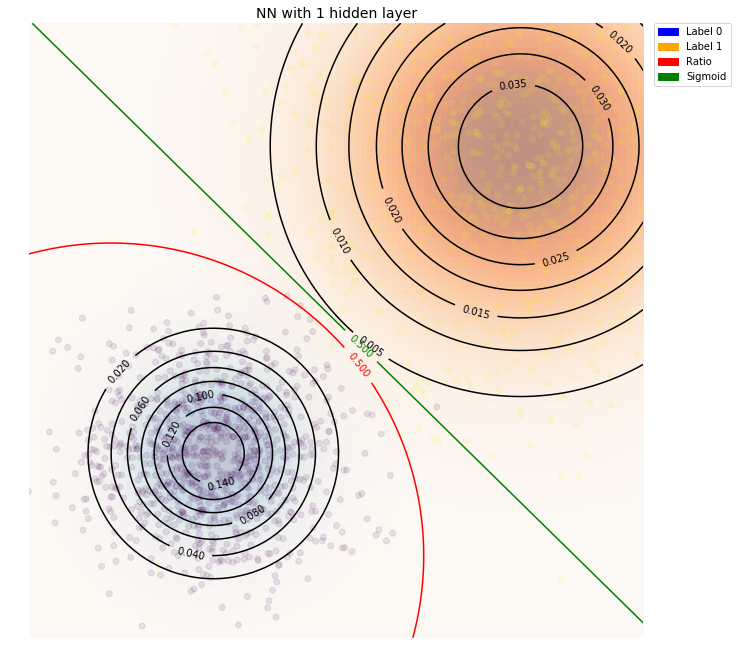

In [4]:
# Test NN with 1 hidden layer
net = nn.Sequential(nn.Linear(2, 1))
net_opt = optim.SGD

net_tester = NetTester(mu0, sigma0, mu1, sigma1, net, net_opt, random_state=42)
net_tester.train_nn(verbose=True)
net_tester.plot_contour(title='NN with 1 hidden layer')

Ошибка после 0 итераций: 0.624734
Ошибка после 1 итераций: 0.405337
Ошибка после 2 итераций: 0.342303
Ошибка после 3 итераций: 0.301303
Ошибка после 4 итераций: 0.265616
Ошибка после 5 итераций: 0.231870
Ошибка после 6 итераций: 0.199419
Ошибка после 7 итераций: 0.169904
Ошибка после 8 итераций: 0.144032
Ошибка после 9 итераций: 0.123659
Ошибка после 10 итераций: 0.106058
Ошибка после 11 итераций: 0.094091
Ошибка после 12 итераций: 0.083572
Ошибка после 13 итераций: 0.075589
Ошибка после 14 итераций: 0.069196
Ошибка после 15 итераций: 0.063842
Ошибка после 16 итераций: 0.059194
Ошибка после 17 итераций: 0.056427
Ошибка после 18 итераций: 0.053421
Ошибка после 19 итераций: 0.050639


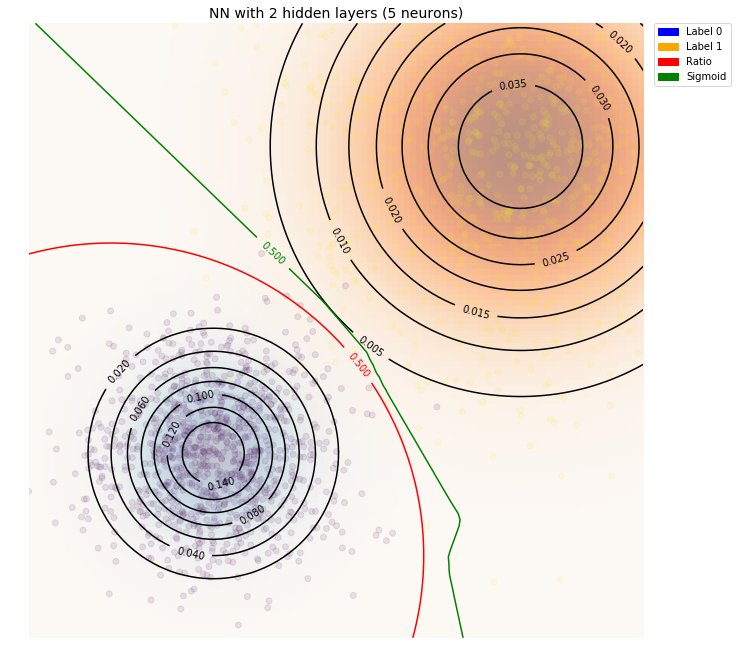

In [10]:
# Test NN with 2 hidden layers (5 neurons)
net = nn.Sequential(nn.Linear(2, 5), nn.ReLU(), 
                    nn.Linear(5, 1))
net_opt = optim.SGD

net_tester = NetTester(mu0, sigma0, mu1, sigma1, net, net_opt, random_state=42)
net_tester.train_nn(verbose=True)
net_tester.plot_contour(title='NN with 2 hidden layers (5 neurons)')

Ошибка после 0 итераций: 0.740813
Ошибка после 1 итераций: 0.221851
Ошибка после 2 итераций: 0.146760
Ошибка после 3 итераций: 0.111892
Ошибка после 4 итераций: 0.090672
Ошибка после 5 итераций: 0.077836
Ошибка после 6 итераций: 0.069378
Ошибка после 7 итераций: 0.062894
Ошибка после 8 итераций: 0.057326
Ошибка после 9 итераций: 0.053968
Ошибка после 10 итераций: 0.049755
Ошибка после 11 итераций: 0.048689
Ошибка после 12 итераций: 0.045522
Ошибка после 13 итераций: 0.044265
Ошибка после 14 итераций: 0.041978
Ошибка после 15 итераций: 0.041248
Ошибка после 16 итераций: 0.039803
Ошибка после 17 итераций: 0.038540
Ошибка после 18 итераций: 0.038231
Ошибка после 19 итераций: 0.037295


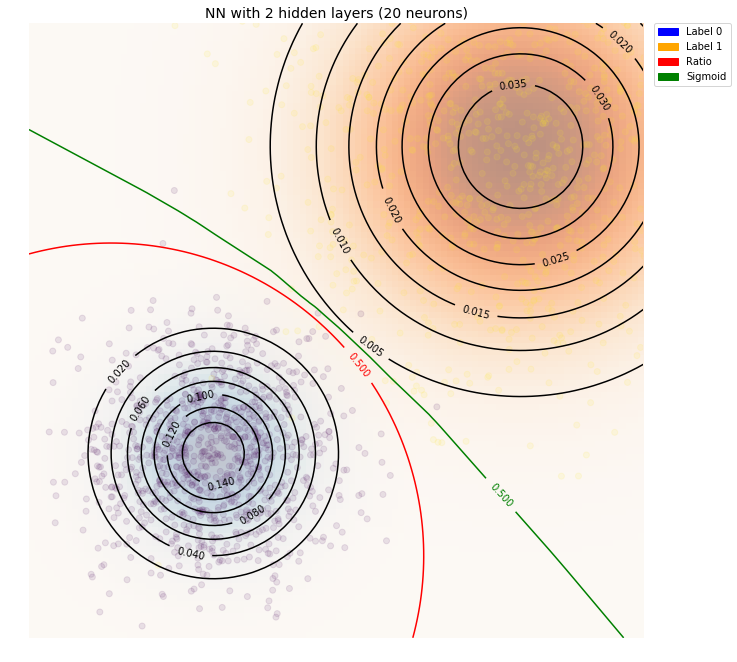

In [11]:
# Test NN with 2 hidden layers (20 neurons)
net = nn.Sequential(nn.Linear(2, 20), nn.ReLU(), 
                    nn.Linear(20, 1))
net_opt = optim.SGD

net_tester = NetTester(mu0, sigma0, mu1, sigma1, net, net_opt, random_state=42)
net_tester.train_nn(verbose=True)
net_tester.plot_contour(title='NN with 2 hidden layers (20 neurons)')

Ошибка после 0 итераций: 0.674516
Ошибка после 1 итераций: 0.593965
Ошибка после 2 итераций: 0.496986
Ошибка после 3 итераций: 0.418410
Ошибка после 4 итераций: 0.359977
Ошибка после 5 итераций: 0.311734
Ошибка после 6 итераций: 0.265397
Ошибка после 7 итераций: 0.219068
Ошибка после 8 итераций: 0.173904
Ошибка после 9 итераций: 0.133935
Ошибка после 10 итераций: 0.102682
Ошибка после 11 итераций: 0.081284
Ошибка после 12 итераций: 0.065801
Ошибка после 13 итераций: 0.056259
Ошибка после 14 итераций: 0.048978
Ошибка после 15 итераций: 0.044476
Ошибка после 16 итераций: 0.040554
Ошибка после 17 итераций: 0.037903
Ошибка после 18 итераций: 0.035987
Ошибка после 19 итераций: 0.033628


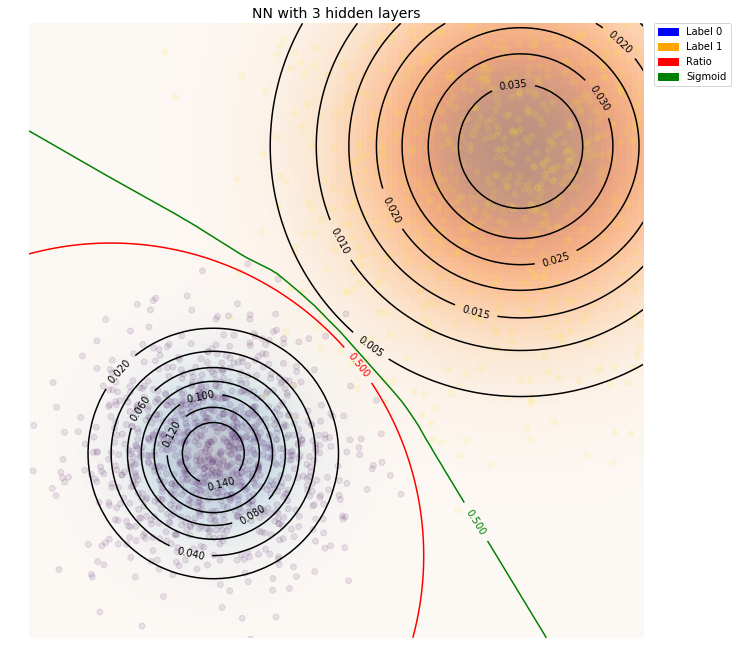

In [12]:
# Test NN with 3 hidden layers
net = nn.Sequential(nn.Linear(2, 20), nn.ReLU(), 
                    nn.Linear(20, 20), nn.ReLU(),
                    nn.Linear(20, 10), nn.ReLU(),
                    nn.Linear(10, 1))
net_opt = optim.SGD

net_tester = NetTester(mu0, sigma0, mu1, sigma1, net, net_opt, random_state=42)
net_tester.train_nn(verbose=True)
net_tester.plot_contour(title='NN with 3 hidden layers')